# **Initialization - Import / Install libraries**


In [1]:
# This is a magic function to generate the graph within the notebook 
%matplotlib inline

# Install library 
!pip install nltk
!pip install pymysql

In [5]:
# Here is a list of libraries we need to conduct the analysis:
import pandas as pd                                                 # Loading files into pandas dataframe
import numpy as np                                                  # To use numpy aggregation functions
from tqdm.auto import tqdm                                          # track loop time
import warnings                                                     # Suppress all warnings
warnings.filterwarnings('ignore')
import pickle
import pymysql
import re
import json
import model_shared_utilities as msu                                # helper functions 
import topic_model_utilities as tm                                  # helper functions
# --------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Generate visualization 
import matplotlib.cm as cm
import altair as alt                                          
import seaborn as sns
# --------------------------------------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler                    # Transforming dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.tokenize import sent_tokenize
# --------------------------------------------------------------------------------------------------
from sklearn.decomposition import NMF, LatentDirichletAllocation    # Model Training
from sklearn.model_selection import train_test_split         
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
# --------------------------------------------------------------------------------------------------
from sklearn.metrics.pairwise import cosine_similarity              # Calculate the similarity between word vectors
# --------------------------------------------------------------------------------------------------
import nltk                                                         # Downloading necessary packagings from nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# use this to set random_state to reproduce the same result
RANDOM_SEED = 14


# **Helper Functions**

In the *model_shared_utilities* module, the functions that might be relevant to this notebook: 


1. generate_avg_silhouette_plot(data, max_k, model, RANDOM_SEED): 
  * plot the average silouette score with different number of clusters
2. generate_tsne_pca_plot(data, pred_clusters, n_clusters, RANDOM_SEED): 
  * generate PCA cluster plot that capture global structure of the data 
  * generate TSNE cluster plot that capture the local distances between neighbors
3. get_top_keywords(data, pred_clusters, terms, n_terms): 
  * get the top n terms for each cluster


In [4]:
# BIC is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred.
# It penalizes the complexity of the model (number of parameters in the model).


def generate_bic_plot(data, max_k):
    """
      this function is to generate Bayesian information criterion (BIC) plot

      Parameters
      ----------
      data: numerical matrix (tfidf transformation of the text data)
      max_k (int): the maximum number of clusters to draw for the SSE plot

      Returns
      -------
      BIC plot
    """


    n_components = range(2, max_k+1, 2)
    models = [GaussianMixture(n, random_state=RANDOM_SEED).fit(data)
              for n in tqdm(n_components)]
    bic = [m.bic(data) for m in tqdm(models)]

    f, ax = plt.subplots(1, 1, figsize=(10,5))

    ax.plot(n_components, bic, marker='o')
    ax.set_xlabel('n_components')
    ax.set_xticks(n_components)
    ax.set_xticklabels(n_components)
    ax.set_ylabel('BIC')
    ax.set_title('BIC Plot')


# **Load / Transform Data**

In [16]:
# read the secret keys from json file 
# Note the config file need to be filled with your own credentials before running this notebook 
# or ask the owners of this repository for the filled config file
with open('config.json', 'r') as f:
    secret = json.load(f)
    

In [18]:
# connect to the database
connection = pymysql.connect(host=secret['host'],
                              user=secret['user'],
                              password=secret['password'],
                              database=secret['database'],
                              port=secret['port'],
                              charset=secret['charset'],
                              cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

cursor.execute("SELECT * FROM jd;")
table = cursor.fetchall()
connection.close()

In [19]:
# Now let's put the table into pandas dataframe 
job_df = pd.DataFrame(table)
job_df = job_df.dropna(subset=['job_description'])

print("Job dataset has", job_df.shape[0], "rows of data")

Job dataset has 18087 rows of data


In [20]:
# remove words that are common in job postings and data science related terms
# notice some terms like "jefferson" and "cybercoders" are recruitment companies 
stopwords = ["job", "summary", "posted", "location" , "employee", "today", "type", "data", "scientist", "level", "experience", "skills", 
             "deep", "learning", "machine", "jobdescriptiontext", "ability", "analytics", "work", "modeling", "models", "analysis", "research", 
             "big", "technical", "requirements", "requirement", "required", "strong", "years", "team", "experienced",
             "rsquo", "nbsp", "reference", "career", "persons", "hired", "eligibility", "applicants", "authorized", "transform",
             "manipulate", "need", "position", "complete", "employment", "document", "verify", "identity", "looking", "equal", "apply", "status",
             "color", "veteran", "religion", "race", "origin", "sexual", "orientation", "opportunity", "disability", "gender", "time", "recruitment", "hiring", 
             "people", "working", "employer", "qualified", "form", "hire", "pregnancy", "marital", "color", "compliance", "federal", "right", "resume", "protected", "applicable", "laws",
             "statistical", "projects", "provide", "reports", "including" , "large", "engineering", "insights" , "computer", "problems",
             "algorithms", "knowledge", "advanced", "statistics", "solutions", "using", "techniques", "statistical", "verification", 
             'build', 'help', 'products', 'teams', 'company', 'building', 'make', 'full', 'please', 'paid', 'jefferson', 'frank', 'cybercoders',    
             'python', 'spark', 'sets', 'mining', 'customers', 'services', 'related', 'degree', 'support', 'information', 'project', 
             'related', 'must','scientists', 'processing', 'language', 'engineers', 'applied',
             'reporting', 'processes', 'analyst', 'customer', 'needs', 'booz', 'allen', 'robert', 'half', 'change', 'answers', 'certifications', 'turn', 'taboola', 'newsroom', 
             'paid', 'preferred', 'schedule', 'benefits', 'year', 'dental', 'vision', 'clearance', 'jobs', 'find', 'organizations', 'jeffersonfrank', 'north', 'america',
             'forward', 'receiving', 'states', 'upon', 'characteristic', 'united', 'national', 'proud', 'receive', 'click', 'consideration', 'without', 'regard',
             'capture', 'methods', 'structured', 'unstructured', 'outcomes', 'analyses', 'read', 'something'
             'drive', 'complex', 'results', 'across', 'sources', 'identify', 'great', 'happy', 'qualifications', 'relevant', 'application', 'essential',
             'field', 'best','perform', 'relevant', 'duties', 'drive', 'analytic', 'role', 'responsibilities', 'join', 'impact', 'science', 'analytical', 'develop', 'quantitative',
             'scale', 'like','opportunities','understanding', 'training', 'access', 'intelligence', 'know', 'world', 'onsite', 'responsibilitie', 'cluster', 
             'four', 'greater', 'case', 'problem', 'interpreting', 'feature', 'carlo', 'bagging', 'professionals', 'deploy', 'nosql', 'interpreting'] 
my_stop_words = set(nltk.corpus.stopwords.words('english')).union(stopwords)

In [21]:
# Let's initiate the TfidfVectorizer and transform the job description 
tfidf_vectorizer = TfidfVectorizer(max_features=10000,              # only top n by freq
                                   lowercase=True,                  # keep caps
                                   token_pattern=r"[A-Za-z]{4,15}", # words with 4 to 15 characters
                                   ngram_range=(1,2),               # include 2-word phrases
                                   min_df=25,                       # note: absolute count of doc
                                   max_df=0.75,                     # note: % of docs
                                   stop_words=my_stop_words)        # default English stopword
tfidf_docs = tfidf_vectorizer.fit_transform(job_df["job_description"])  
print(tfidf_docs.shape)
tfidf_terms = tfidf_vectorizer.get_feature_names()

(18087, 10000)


# **Model Training**

From what we observed from TSNE cluster plot and PCA cluster plot from the KMeans, there are lot of overlaps between the clusters. For the second model, we want to try the [Gaussian Mixture Model](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html), which is a probabilistic model that assumes the data are generated from a mixture of Gaussian distributions. The methods we will use to evaluate the quality of the clusters: 
1. **Average Silhouette Plot**: silhouette score measure how close each point in one cluster is to points in the neighboring clusters. Near +1 indicate that the sample is far away from the neighboring clusters; 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters; negative values indicate that those samples might have been assigned to the wrong cluster. 
2. **BIC Plot**: Bayesian information criterion is a built-in method from the sklearn GMM model. BIC is an estimation on how good the GMM in terms of predicting the data we have. The lower is the BIC, the better is the model to actually predict the data. The model with the lowest BIC is preferred.

## Gaussian Mixture Model

In [22]:
# Let's reduce the number of dimensions so that we can generate multiple models with different number of clusters
pca = PCA(n_components=2000, random_state=RANDOM_SEED)
pca_docs = pca.fit_transform(tfidf_docs.todense())
pca.explained_variance_ratio_.sum()

0.7947191723358845

  0%|          | 0/15 [00:00<?, ?it/s]

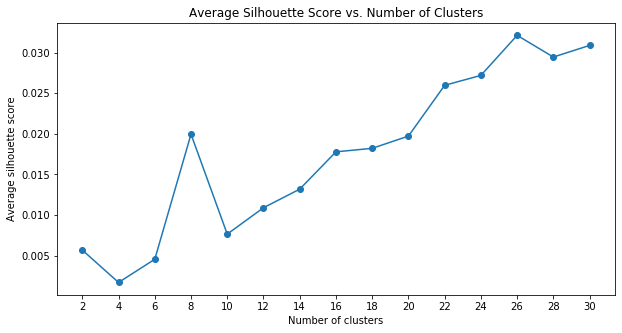

In [23]:
# plot the average silouette scores for each number of cluster
msu.generate_avg_silhouette_plot(pca_docs, 30, 'GMM', RANDOM_SEED)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

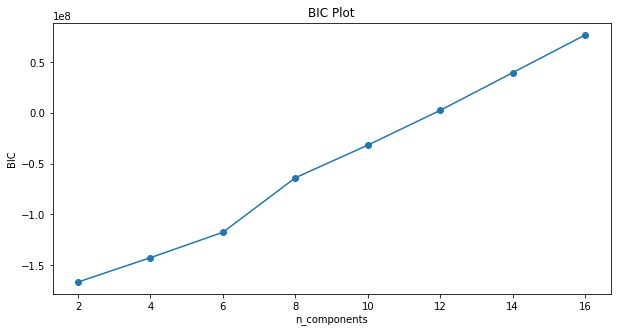

In [24]:
generate_bic_plot(pca_docs, 16)

In [25]:
# From the average silhouette plot, we can see there is a jump for n_cluster = 8 
# so let's look at the result for 8 clusters 
GMM = GaussianMixture(n_components=8, random_state=RANDOM_SEED)
clusters_labels = GMM.fit_predict(pca_docs)

In [26]:
msu.get_top_keywords(tfidf_docs, clusters_labels, tfidf_terms, 10)


Cluster 0
design,predictive,technology,marketing,financial,development,product,tools,management,business

Cluster 1
telecommuter,telecommute,drug,care,health care,health,group,optum,unitedhealth group,unitedhealth

Cluster 2
security,technologies,technology,engineer,business,cloud,design,systems,development,software

Cluster 3
development,business,quality,medical,patients,patient,care,health,healthcare,clinical

Cluster 4
business society,challenge,reinventing,ibmer,business,next challenge,clients,professional expertise,ibmers,progressive

Cluster 5
money live,largest retailer,live better,example,mission,walmart ecommerce,business,ecommerce,shopping,walmart

Cluster 6
leaders partnership,premier social,online presentation,good competition,portal specifically,presentation methodologies,towards functional,power dedicated,public sectors,online

Cluster 7
networks logistics,outliers hands,prescriptive meet,monte visualizations,communicate graphical,srss specializes,bachelor mathematic,pub